Implementation of UNet architecture to the Pascal VOC 2012 semantic segmentation dataset.

## [Paper](https://arxiv.org/abs/1505.04597)

## Imports

In [1]:
import os
import math
import time
import random

import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt 
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import functional as TF

# Fix random seed
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using {device}")

Using cuda:0


## Dataset

Download data from official site, define transforms and load images. Torchvision transforms are not applied to the target image, so we define them by hand as done in https://github.com/pytorch/vision/blob/master/references/segmentation/transforms.py



In [2]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


In [3]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = TF.resize(image, self.size)
        target = TF.resize(target, self.size)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, flip_prob=0.5):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = TF.hflip(image)
            target = TF.hflip(target)
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = TF.to_tensor(image)
        
        target = np.array(target, dtype=np.float32)
        target = TF.to_tensor(target).long()

        return image, target.squeeze()


In [4]:
train_augmentation = Compose(
    [
        RandomHorizontalFlip(),
        Resize((256, 256)),
        ToTensor(),
    ]
)

test_augmentation = Compose([Resize((256, 256)), ToTensor()])


train_data = VOCSegmentation(
    "sample_data", download=True, transforms=train_augmentation
)
test_data = VOCSegmentation(
    "sample_data", image_set="val", download=True, transforms=test_augmentation
)


Using downloaded and verified file: sample_data/VOCtrainval_11-May-2012.tar
Extracting sample_data/VOCtrainval_11-May-2012.tar to sample_data
Using downloaded and verified file: sample_data/VOCtrainval_11-May-2012.tar
Extracting sample_data/VOCtrainval_11-May-2012.tar to sample_data


## Model

In [5]:
class UNetBlock(nn.Module):
    """
    U-Net block:
      performs downsampling -> | submodule | -> upsample
      and the skip connection between the downsampling and upsampling layers
    """

    def __init__(
        self,
        output_channels,
        num_filters,
        input_channels=None,
        submodule=None,
        outermost=False,
        innermost=False,
        dropout=None,
    ):
        """
        Parameters
        ----------
        output_channels: int
          Number of filter in the outer convolution layer.
        num_filters: int
          Number of filter in the inner convolution layer.
        input_channels: int
          Number of channels from the input image/activation maps
        submodule: nn.Module
          Submodule to run after downsampling and before upsampling
         outermost: bool
          Whether the block is the outermost one
        innermost: bool
          Whether the block is the innermost one
        dropout: float
          Dropout probability to apply to the module, defualts to None
        """
        super(UNetBlock, self).__init__()
        self.outermost = outermost

        if not input_channels:
          input_channels = output_channels

        down_module = self._get_downsampling_module(
            input_channels, num_filters, outermost, innermost
        )
        up_module = self._get_upsampling_module(
            num_filters, output_channels, outermost, innermost
        )

        if submodule:
          modules = down_module + [submodule] + up_module
        else:
          modules = down_module + up_module

        if dropout:
            modules = modules + [nn.Dropout(dropout)]
            
        self.model = nn.Sequential(*modules)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            # skip connections
            return torch.cat([x, self.model(x)], 1)

    def _get_downsampling_module(
        self, input_channels, num_filters, outermost, innermost
    ):
        conv = nn.Conv2d(
            in_channels=input_channels,
            out_channels=num_filters,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False,
        )

        if outermost:
            modules = [conv]
        elif innermost:
            modules = [nn.LeakyReLU(0.2), conv]
        else:
            modules = [nn.LeakyReLU(0.2), conv, nn.BatchNorm2d(num_filters)]
        return modules

    def _get_upsampling_module(
        self, num_filters, output_channels, outermost, innermost
    ):
        up_input_channels = num_filters if innermost else num_filters * 2
        activation = nn.ReLU()

        conv = nn.ConvTranspose2d(
            in_channels=up_input_channels,
            out_channels=output_channels,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=outermost,
        )

        modules = [activation, conv]
        if not outermost:
          modules.append(nn.BatchNorm2d(output_channels))

        return modules


In [6]:
class UNet(nn.Module):
    """
    UNet (Encoder - Decoder) architecture (same used in my pix2pix implementation),
    decomposes input image into a latent representation
    and builds output based on it using skip connections between layers.
    """

    def __init__(self, input_channels, output_channels):
        super(UNet, self).__init__()

        # Start building from the inside out
        u_net_block = UNetBlock(output_channels=512, num_filters=512, innermost=True)
        u_net_block = UNetBlock(
            output_channels=512, num_filters=512, submodule=u_net_block,
        )
        u_net_block = UNetBlock(
            output_channels=512, num_filters=512, submodule=u_net_block,
        )
        u_net_block = UNetBlock(
            output_channels=512, num_filters=512, submodule=u_net_block,
        )
        u_net_block = UNetBlock(
            output_channels=256, num_filters=512, submodule=u_net_block
        )
        u_net_block = UNetBlock(
            output_channels=128, num_filters=256, submodule=u_net_block
        )
        u_net_block = UNetBlock(
            output_channels=64, num_filters=128, submodule=u_net_block
        )

        self.model = UNetBlock(
            input_channels=input_channels,
            num_filters=64,
            output_channels=output_channels,
            outermost=True,
            submodule=u_net_block,
        )

    def forward(self, x):
        return self.model(x)


## Training

In [7]:
def pixel_accuracy(preds, label):
    probs = torch.log_softmax(preds, dim=1)
    predictions = torch.argmax(probs, dim=1)
    corrects = (predictions == label).float()
    acc = corrects.sum() / corrects.numel()
    
    return acc.cpu()


def train_epoch(
    model,
    optimizer,
    dataloader,
    loss,
):
    model.train()
    epoch_loss = 0
    all_accuracies = []

    for input_images, targets in dataloader:
      optimizer.zero_grad()
      targets = targets.to(device)

      predictions = model(input_images.to(device))
      all_accuracies.append(pixel_accuracy(predictions, targets))

      cost = loss(predictions, targets)
      epoch_loss += cost.item()

      cost.backward()
      optimizer.step()
    
    return epoch_loss / len(dataloader), np.mean(all_accuracies)

def test_epoch(
    model,
    optimizer,
    dataloader,
    loss,
):
    model.eval()
    epoch_loss = 0
    all_accuracies = []

    with torch.no_grad():
      for input_images, targets in dataloader:
        predictions = model(input_images.to(device))
        targets = targets.to(device)

        cost = loss(predictions, targets)
        epoch_loss += cost.item()

        all_accuracies.append(pixel_accuracy(predictions, targets))

    return epoch_loss / len(dataloader), np.mean(all_accuracies)



In [8]:
def segmentation_train(
    model,
    optimizer,
    lr_scheduler,
    train_dataloader,
    val_dataloader,
    epochs=50,
):
    train_loss_hist = []
    train_acc_hist = []
    val_loss_hist = []
    val_acc_hist = []

    best_model_weights = None
    best_val_loss = math.inf

    loss_function = nn.CrossEntropyLoss(ignore_index=255).to(device)

    for epoch in range(epochs):
        start = time.time()
        train_loss, train_acc = train_epoch(
            model, optimizer, train_dataloader, loss_function
        )
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)

        val_loss, val_acc = test_epoch(
            model, optimizer, train_dataloader, loss_function
        )
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_model_weights = model.state_dict().copy()

        lr_scheduler.step()

        print(
            f"Epoch {epoch + 1} | "
            f"Train Loss {train_loss:.6f} | "
            f"Train pixel accuracy {train_acc:.2f} | "
            f"Val Loss {val_loss:.6f} | "
            f"Validation pixel accuracy {val_acc:.2f} | "
            f"Time {time.time() - start:.2f} sec"
        )
    
    model.load_state_dict(best_model_weights)

    return (
        train_loss_hist,
        val_loss_hist,
        train_acc_hist,
        val_acc_hist,
    )


## Results

In [9]:
PASCAL_VOC_CLASSES = len(VOC_CLASSES)

train_dataloader = DataLoader(
    train_data, batch_size=32, num_workers=2, pin_memory=True
)
val_dataloader = DataLoader(test_data, batch_size=32, num_workers=2, pin_memory=True)

# Define model
u_net_model = UNet(input_channels=3, output_channels=PASCAL_VOC_CLASSES).to(device)

net_optimizer = torch.optim.Adam(u_net_model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(net_optimizer, step_size=100)

Epoch 1 | Train Loss 1.472619 | Train pixel accuracy 0.66 | Val Loss 1.358746 | Validation pixel accuracy 0.69 | Time 41.39 sec
Epoch 2 | Train Loss 1.216413 | Train pixel accuracy 0.69 | Val Loss 1.336694 | Validation pixel accuracy 0.69 | Time 39.03 sec
Epoch 3 | Train Loss 1.199426 | Train pixel accuracy 0.69 | Val Loss 1.210755 | Validation pixel accuracy 0.69 | Time 38.61 sec
Epoch 4 | Train Loss 1.180930 | Train pixel accuracy 0.69 | Val Loss 1.232192 | Validation pixel accuracy 0.69 | Time 38.98 sec
Epoch 5 | Train Loss 1.166847 | Train pixel accuracy 0.69 | Val Loss 1.177175 | Validation pixel accuracy 0.69 | Time 38.81 sec
Epoch 6 | Train Loss 1.144952 | Train pixel accuracy 0.69 | Val Loss 1.173357 | Validation pixel accuracy 0.69 | Time 38.91 sec
Epoch 7 | Train Loss 1.121159 | Train pixel accuracy 0.69 | Val Loss 1.163906 | Validation pixel accuracy 0.69 | Time 38.65 sec
Epoch 8 | Train Loss 1.089855 | Train pixel accuracy 0.70 | Val Loss 1.076496 | Validation pixel accurac

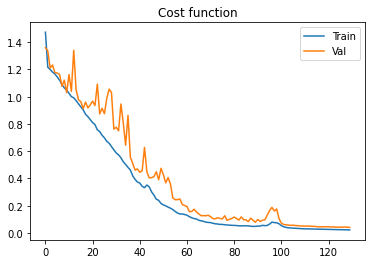

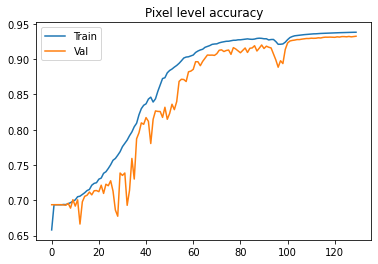

In [10]:
N_EPOCHS = 130

train_losses, val_losses, train_acc, val_acc = segmentation_train(
    u_net_model, net_optimizer, scheduler, train_dataloader, val_dataloader, epochs=N_EPOCHS
)

plt.plot(range(N_EPOCHS), train_losses, label="Train")
plt.plot(range(N_EPOCHS), val_losses, label="Val")
plt.legend()
plt.title("Cost function")
plt.show()

plt.plot(range(N_EPOCHS), train_acc, label="Train")
plt.plot(range(N_EPOCHS), val_acc, label="Val")
plt.legend()
plt.title("Pixel level accuracy")
plt.show()


### Visualizations

In [11]:
def mask_to_image(mask):
  VOC_COLORMAP
  image = np.zeros((256, 256, 3))
  for class_idx, colour in enumerate(VOC_COLORMAP):
    image[mask == class_idx, :] = colour

  return image.astype(np.uint8)

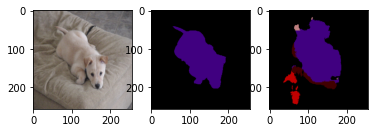

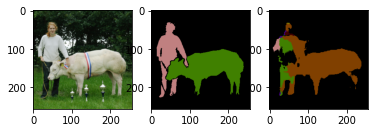

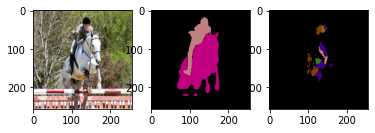

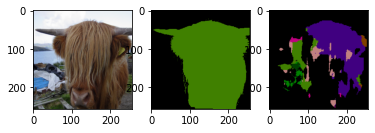

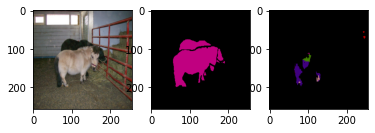

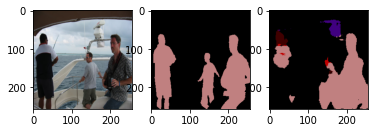

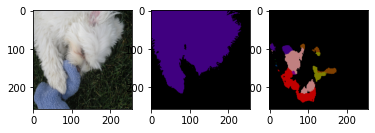

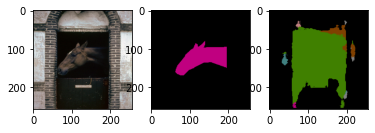

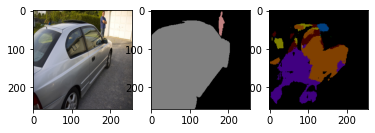

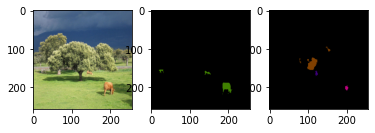

In [12]:
vis_dataloader = DataLoader(test_data, batch_size=10, num_workers=2, shuffle=True)
vis_batch, targets = next(iter(vis_dataloader))

predictions = torch.softmax(u_net_model(vis_batch.to(device)), dim=1)
predictions = torch.argmax(predictions, dim=1)


for idx, image in enumerate(vis_batch):
  fig, axes = plt.subplots(nrows=1, ncols=3)
  axes[0].imshow(image.cpu().numpy().transpose(1, 2, 0))
  axes[1].imshow(mask_to_image(targets[idx]))
  axes[2].imshow(mask_to_image(predictions[idx].cpu()))
